In [ ]:
%%capture
!pip install -U sentence_transformers 

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
import nltk
import pandas as pd
import numpy as np

from nltk.tokenize import sent_tokenize
from tqdm.auto import tqdm, trange
from copy import copy

from multiprocessing import Pool
import torch
import time
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
DATA_PATH = "gdrive/MyDrive/gaz/data"

# PREPROCESSING

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return ''.join([i for i in text if i not in PUNCT_TO_REMOVE])

def remove_non_words(text):
    return ' '.join(re.findall(r'\b[^\d\W]+\b', text))

STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('fig')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_short_words(text):
    return " ".join([i for i in str(text).split() if len(i) >= 3])

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return " ".join([lemmatizer.lemmatize(word, pos="v") for word in text.split()])


def preprocess(text):
    pipeline = (remove_urls, remove_punctuation, remove_non_words, lemmatize, remove_stopwords, remove_short_words)
    for func in pipeline:
        text = func(text)

    return text


def split_to_sentences(article):
    text, pii = article

    sents = sent_tokenize(text)
    sents_original = copy(sents)
    sents = [preprocess(sent.lower()) for sent in sents]
    good_sents = [idx for idx, sent in enumerate(sents) if 3 < len(sent.split()) < 100]
    sents = [sents[i] for i in good_sents]
    sents_original = [sents_original[i] for i in good_sents]

    piis = [pii for i in sents]
    return list(zip(sents, sents_original, piis))

def get_sentences(n_processes):
    articles = pd.read_csv(DATA_PATH + "/health_ng.csv")
    sentences = []
    
    for item in tqdm(zip(articles['text'].values, articles['pii'].values), total=len(articles)):
        yield split_to_sentences(item)
    # with Pool(n_processes) as pool:
    #     for sents in tqdm(pool.imap_unordered(split_to_sentences, zip(articles['text'].values, articles['pii'].values)), total=len(articles)):
    #         yield sents

In [ ]:
articles = pd.read_csv(DATA_PATH + "/health_ng.csv")

In [ ]:
sentences = [preprocess(sent.lower()) for sent in tqdm(articles['text'].values)]
# for i in get_sentences(2):
#     sentences += i

  0%|          | 0/1923 [00:00<?, ?it/s]

In [ ]:
sentences.to_csv(DATA_PATH + "/sentences.csv", index=False)

# ВЕКТОРИЗАЦИЯ

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = SentenceTransformer("paraphrase-MiniLM-L12-v2")

In [ ]:
corpus_embeddings = model.encode(sentences['text_original'], 
                                 batch_size=128, 
                                 show_progress_bar=True, 
                                 convert_to_tensor=False, 
                                 normalize_embeddings=False)

In [ ]:
corpus_embeddings.shape

(498915, 384)

In [ ]:
with open(DATA_PATH + '/corpus_embeddings.npy', 'wb') as f:
    np.save(f, corpus_embeddings)

In [ ]:
del model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# PCA

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 272 (delta 56), reused 38 (delta 19), pack-reused 171
Receiving objects: 100% (272/272), 79.66 KiB | 1007.00 KiB/s, done.
Resolving deltas: 100% (118/118), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:35
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable core

Installing RAPIDS Stable 21.06
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.0      |       h9c3ff4c_0        1011 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.1.0                |   py37h89c1867_0         136 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0          13 KB  conda-fo

# CLUSTERIGNG

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS, MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import cuml
import gc

In [ ]:
with open(DATA_PATH + '/corpus_embeddings.npy', 'rb') as f:
    vectors = np.load(f)

vectors = normalize(vectors)

In [ ]:
vectors_reduced = cuml.UMAP(n_neighbors=10, random_state=11).fit_transform(vectors)
# trained_TSNE = cuml.TSNE(random_state=11).fit(vectors)
# vectors_reduced = cuml.TSNE().fit_transform(vectors)
# pca = PCA(n_components=100)
# pca.fit(vectors)

# print(pca.explained_variance_ratio_.sum())


In [ ]:
vectors.dtype, vectors_reduced.dtype

(dtype('float32'), dtype('float32'))

In [ ]:
vectors_reduced.min()

-2777.5088

(-10.0, 10.0)

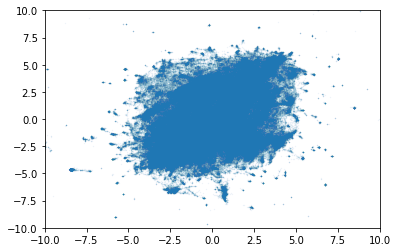

In [ ]:
plt.scatter(vectors_reduced[:, 0], vectors_reduced[:, 1], alpha=.1, s=.1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [ ]:
del corpus_embeddings, vectors
gc.collect()

1675

In [ ]:
# vectors_reduced = pca.transform(vectors)
with open(DATA_PATH + '/vectors_reduced.npy', 'wb') as f:
    np.save(f, vectors_reduced)

In [ ]:
# clusterer = MiniBatchKMeans(n_clusters=10)
# clusterer.fit(vectors_reduced)
clusterer = cuml.DBSCAN(min_samples=10000, max_mbytes_per_batch=6000)
cluster_labels = clusterer.fit_predict(vectors_reduced)

In [ ]:
cluster_labels.max()

-1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


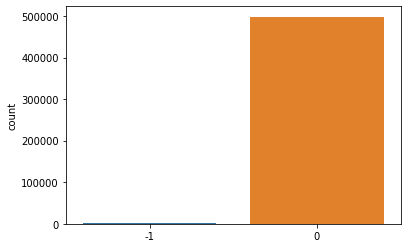

In [ ]:
sns.countplot(cluster_labels)

(-5.0, 5.0)

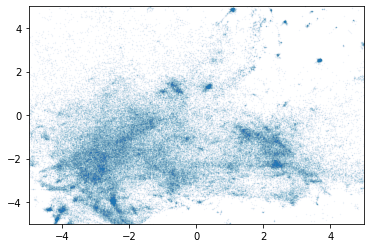

In [ ]:
plt.scatter(vectors_reduced[cluster_labels == 0, 0], vectors_reduced[cluster_labels == 0, 1], alpha=.1, s=.1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [ ]:
cluster_labels.max()

3

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


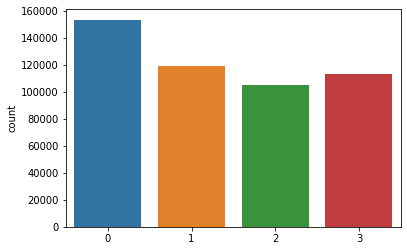

In [ ]:
sns.countplot(cluster_labels)

In [ ]:
sentences = pd.read_csv(DATA_PATH + "/sentences.csv")
sentences.head()

,text,text_original,pii
0,recent years legislation introduce particle nu...,"In recent years, legislation introduced partic...",S0016236120330714
1,major effect wide implementation diesel partic...,"The major effect, was the wide implementation ...",S0016236120330714
2,parallel several research investigations repor...,"In parallel, several research investigations [...",S0016236120330714
3,conventional multi point port injection mpi en...,The more conventional multi point port injecti...,S0016236120330714
4,limit emissions gasolines introduce effective,A limit for the PN emissions of DI gasolines w...,S0016236120330714


In [ ]:
sentences['label'] = cluster_labels

In [ ]:
sentences.to_csv(DATA_PATH + "/sentences_labeled.csv", index=False)

In [ ]:
def extract_keywords(text):
  text = text.lower()
  tokens = [token for token in re.findall(r'(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))', text) if len(token) > 2 and token not in STOPWORDS]
  c = Counter(tokens)
  return c.most_common(20)

In [ ]:
label_to_keywords = {}
for label in trange(sentences['label'].max()+1):
  text = ' '.join(sentences.loc[sentences['label'] == label]['text'].astype(str)).replace('nan', '')
  label_to_keywords[label] = extract_keywords(text=text)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
label_to_keywords

{0: [('use', 19073),
  ('show', 9052),
  ('increase', 9029),
  ('also', 8990),
  ('study', 8393),
  ('result', 8228),
  ('surface', 7074),
  ('process', 6826),
  ('high', 6100),
  ('effect', 5514),
  ('structure', 5309),
  ('water', 5267),
  ('cells', 5205),
  ('sample', 5068),
  ('different', 5049),
  ('materials', 5019),
  ('properties', 5018),
  ('time', 5015),
  ('model', 4888),
  ('however', 4725)],
 1: [('use', 16555),
  ('model', 8345),
  ('data', 8264),
  ('study', 7505),
  ('result', 6533),
  ('also', 6202),
  ('increase', 5604),
  ('energy', 5477),
  ('time', 5270),
  ('show', 5266),
  ('process', 4939),
  ('include', 4588),
  ('value', 4424),
  ('sample', 4412),
  ('system', 4370),
  ('different', 4354),
  ('base', 4153),
  ('test', 4037),
  ('analysis', 4021),
  ('change', 3825)],
 2: [('use', 15296),
  ('energy', 14573),
  ('fuel', 8883),
  ('gas', 7701),
  ('increase', 7240),
  ('emissions', 6952),
  ('process', 6586),
  ('also', 6214),
  ('heat', 5798),
  ('power', 5572)